In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Part1. EDA

In [3]:
print('train data shape: ', train.shape)
print('test data shape: ', test.shape)
print('feature columns not in test data: ', set(train.columns[:-1]).difference(set(test.columns)))

train data shape:  (8600, 12)
test data shape:  (2286, 9)
feature columns not in test data:  {'registered', 'casual'}


In [4]:
train.isnull().values.any(), test.isnull().values.any()

(False, False)

In [5]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [6]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,8600.000000,8600.000000,8600.000000,8600.00000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000
mean,2.505581,0.027791,0.682558,1.41000,20.119653,23.560989,61.590581,12.756693,35.689419,154.840814,190.530233
std,1.116628,0.164382,0.465508,0.63234,8.000975,8.690173,19.468443,8.209822,49.571896,150.760096,180.631042
min,1.000000,0.000000,0.000000,1.00000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.00000,13.940000,16.665000,46.000000,7.001500,4.000000,36.000000,41.000000
50%,3.000000,0.000000,1.000000,1.00000,20.500000,24.240000,61.000000,11.001400,16.000000,118.000000,144.000000
75%,4.000000,0.000000,1.000000,2.00000,27.060000,31.060000,78.000000,16.997900,48.000000,221.000000,282.000000
max,4.000000,1.000000,1.000000,4.00000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


## Extract time information

In [7]:
def transform_time(d):
    d['hour'] = d['datetime'].apply(lambda x: int(x[11:13]))
    d['date'] = d['datetime'].apply(lambda x: x[:10])
    d['weekday'] = d['date'].apply(lambda s: date(*(int(i) for i in s.split('-'))).weekday() + 1)
    d['month'] = d['date'].apply(lambda s: int(s[5:7]))
    d['day'] = d['date'].apply(lambda s: int(s[8:10]))
    d['year'] = d['date'].apply(lambda s: int(s[:4]))
    # 注意monday是0， sunday是6，所以最后加1

transform_time(train)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,weekday,month,day,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,2011-01-01,6,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,2011-01-01,6,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,2011-01-01,6,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,2011-01-01,6,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,2011-01-01,6,1,1,2011


drop datetime

In [8]:
train.drop(['datetime', 'date'], axis=1, inplace=True)

## Linear and non-linear relationships

In [9]:
from sklearn.feature_selection import mutual_info_regression

df_corr = pd.DataFrame(train.corr()['count'])
df_corr.columns = ['corr_coef']
mut_reg = mutual_info_regression(train, train['count'])
df_corr['mut_reg'] = mut_reg.tolist()
df_corr.sort_values(by='corr_coef', ascending=False)

,corr_coef,mut_reg
count,1.000000,6.105008
registered,0.971264,2.265966
casual,0.689973,0.736320
hour,0.400160,0.629286
temp,0.397756,0.156145
atemp,0.397693,0.152777
year,0.260737,0.031105
month,0.181504,0.078783
season,0.178462,0.062222
windspeed,0.116592,0.021008


hour, temp, atemp, year, month, season, windspeed have larger impact on count

### Count distribution

skewness before transformation 1.239241376322606
skewness after transformation 0.8494341585491003


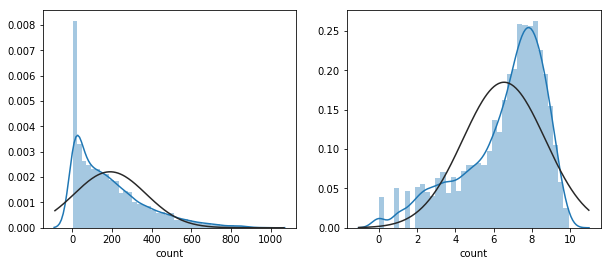

In [10]:
from scipy.stats import norm, skew
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(train['count'], fit=norm);
plt.subplot(1, 2, 2)
sns.distplot(np.log2(train['count']), fit=norm);
print('skewness before transformation', np.abs(skew(train['count'])))
# transform count
train['count'] = np.log2(train['count'] + 1)
print('skewness after transformation', np.abs(skew(train['count'])))

after log transformation, skewness of count decreases

## Count Correlations

### season vs count

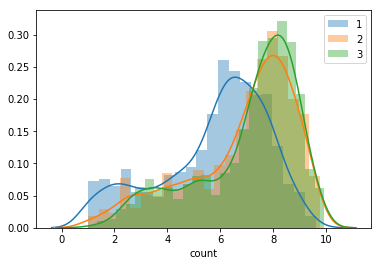

In [11]:
sns.distplot(train.loc[train['season']==1]['count'], label='1')
sns.distplot(train.loc[train['season']==2]['count'], label='2')
sns.distplot(train.loc[train['season']==3]['count'], label='3')
plt.legend()

- the distribution of season 1 is very different from ohter seasons
- other seasons have similar distribution

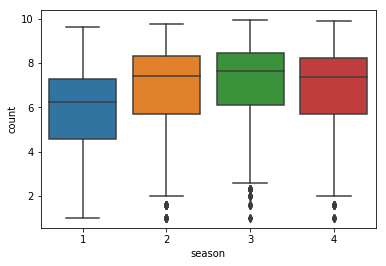

In [12]:
sns.boxplot('season', 'count', data=train);

count increases over season

### holiday vs count

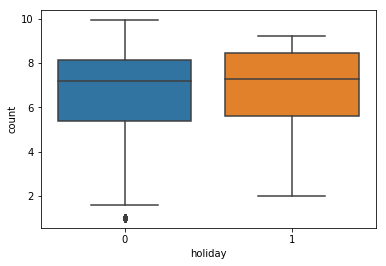

In [13]:
sns.boxplot('holiday', 'count', data=train);

count is slightly higher on holidays

### holiday, season vs count

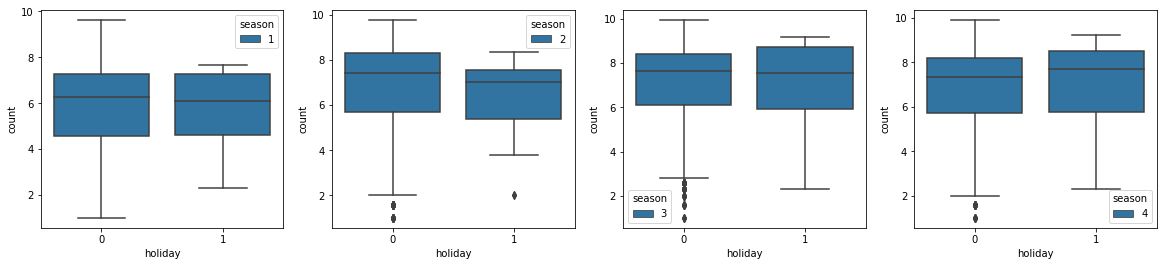

In [14]:
plt.subplots(1, 4, figsize=(20,4))
plt.subplot(1, 4, 1)
sns.boxplot('holiday', 'count', hue='season',  data=train.loc[train['season']==1]);

plt.subplot(1, 4, 2)
sns.boxplot('holiday', 'count', hue='season',  data=train.loc[train['season']==2]);

plt.subplot(1, 4, 3)
sns.boxplot('holiday', 'count', hue='season',  data=train.loc[train['season']==3]);

plt.subplot(1, 4, 4)
sns.boxplot('holiday', 'count', hue='season',  data=train.loc[train['season']==4]);



In [15]:
train.groupby(['holiday','season'])['count'].median().unstack()

season,1,2,3,4
holiday,,,,
0,6.247928,7.434628,7.622052,7.348728
1,6.108524,7.020273,7.527472,7.682785


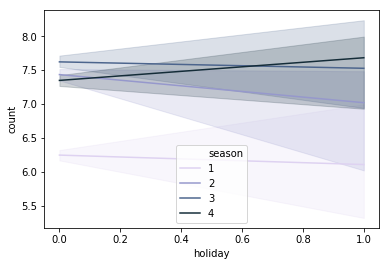

In [16]:
sns.lineplot('holiday', 'count', hue='season', data=train, estimator=np.median, markers=True,palette="ch:2.5,.25");

- only in season 4, count on holiday is slighly higher than count on non-holiday
- in season 2, count on holiday is much lower than count on non-holiday
- season 1 and 3, count on holiday is slightly lower than count on non-holiday

### workingday vs count

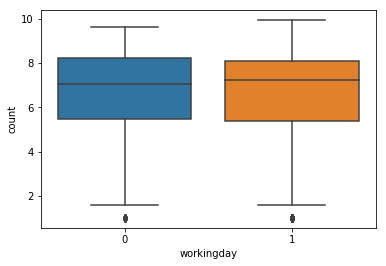

In [17]:
sns.boxplot('workingday', 'count', data=train);

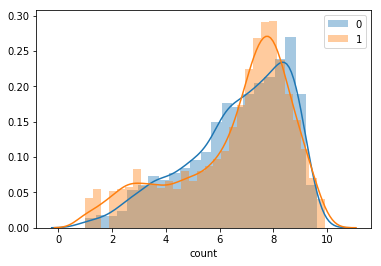

In [18]:
sns.distplot(train.loc[train['workingday']==0]['count'], label='0')
sns.distplot(train.loc[train['workingday']==1]['count'], label='1')

plt.legend()

### workingday, holiday vs count

In [19]:
train.groupby(['workingday', 'holiday'])['count'].median().unstack()

holiday,0,1
workingday,,
0,7.000000,7.276124
1,7.219169,NaN


when holiday=1, workingday=0

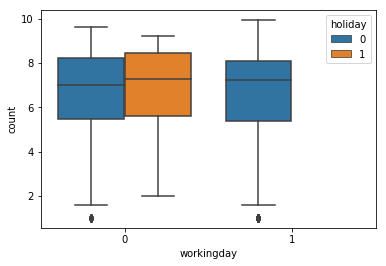

In [20]:
sns.boxplot('workingday', 'count', data=train, hue='holiday');

### workingday, season vs count

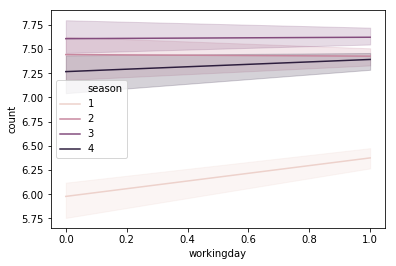

In [21]:
sns.lineplot('workingday', 'count', data=train, hue='season', estimator=np.median);

### weather vs count

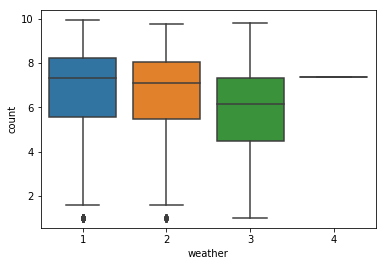

In [22]:
sns.boxplot('weather','count', data=train)

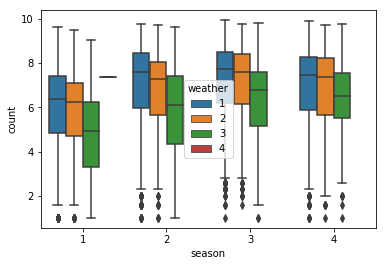

In [23]:
sns.boxplot('season','count', data=train, hue='weather')

In [24]:
train.groupby(['weather', 'season'])['count'].median().unstack()

season,1,2,3,4
weather,,,,
1,6.392317,7.592457,7.734710,7.442943
2,6.247928,7.266787,7.584963,7.370681
3,4.906891,6.087463,6.781300,6.491764
4,7.366322,NaN,NaN,NaN


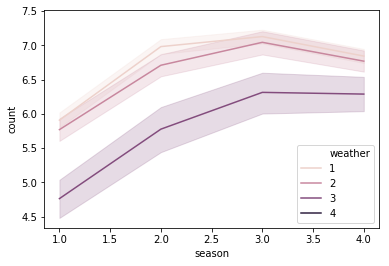

In [25]:
sns.lineplot('season', 'count', data=train, hue='weather');

### temp vs count

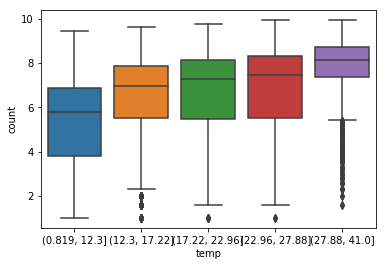

In [26]:
tempbin = pd.qcut(train['temp'], 5)
sns.boxplot(tempbin, 'count', data=train)

### season, temp vs count

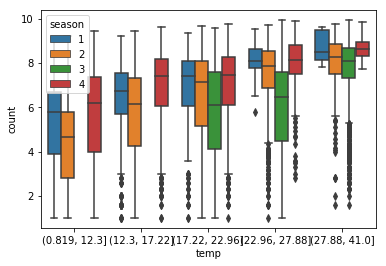

In [27]:
tempbin = pd.qcut(train['temp'], 5)
sns.boxplot(tempbin, 'count', data=train, hue='season');

In [28]:
train.groupby(['season', pd.qcut(train['temp'], 5)])['count'].size().unstack()

temp,"(0.819, 12.3]","(12.3, 17.22]","(17.22, 22.96]","(22.96, 27.88]","(27.88, 41.0]"
season,,,,,
1,1292.0,566.0,214.0,42.0,13.0
2,61.0,367.0,774.0,624.0,331.0
3,NaN,NaN,119.0,724.0,1314.0
4,459.0,867.0,611.0,193.0,29.0


### temp vs atemp

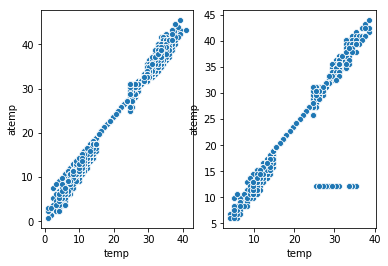

In [29]:
plt.subplot(1,2,1)
sns.scatterplot('temp', 'atemp', data=train);
plt.subplot(1,2,2)
sns.scatterplot('temp', 'atemp', data=test);

highly correlated, but in test, there are unusual temp or atemp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
1830,2012-08-17 00:00:00,3,0,1,1,27.88,12.12,57,11.0014
1831,2012-08-17 01:00:00,3,0,1,1,27.06,12.12,65,7.0015
1832,2012-08-17 02:00:00,3,0,1,1,27.06,12.12,61,8.9981
1833,2012-08-17 03:00:00,3,0,1,1,26.24,12.12,65,7.0015
1834,2012-08-17 04:00:00,3,0,1,1,26.24,12.12,73,11.0014
1835,2012-08-17 05:00:00,3,0,1,1,26.24,12.12,73,7.0015
1836,2012-08-17 06:00:00,3,0,1,1,25.42,12.12,78,8.9981
1837,2012-08-17 07:00:00,3,0,1,1,26.24,12.12,73,7.0015
1838,2012-08-17 08:00:00,3,0,1,1,27.88,12.12,65,8.9981
1839,2012-08-17 09:00:00,3,0,1,1,28.70,12.12,58,7.0015


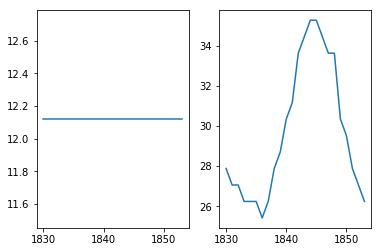

In [30]:
df_unusual = test.loc[(test['atemp']<15) & (test['temp']>20)]
plt.subplot(1,2,1)
plt.plot(df_unusual.atemp)
plt.subplot(1,2,2)
plt.plot(df_unusual.temp)
df_unusual

- all unusual point belong to 2012-08-17, according to weather, atemp seems missing
- since atemp and temp are highly correlated, remove atemp

### humidity vs count

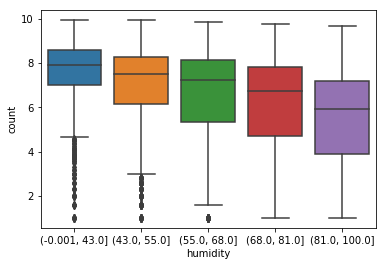

In [31]:
humidbin = pd.qcut(train['humidity'], 5)
sns.boxplot(humidbin, 'count', data=train)

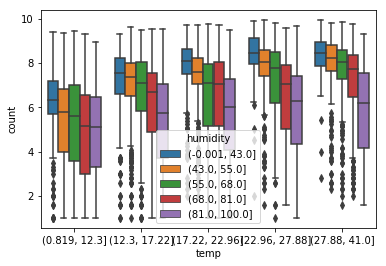

In [32]:
humidbin = pd.qcut(train['humidity'], 5)
sns.boxplot(tempbin, 'count', data=train, hue=humidbin)

### windspeed vs count

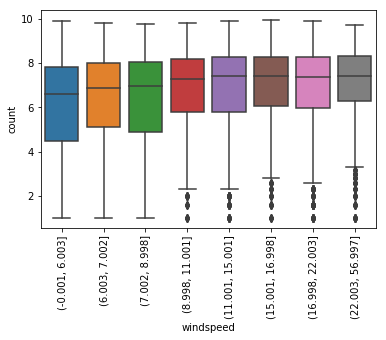

In [33]:
windbin = pd.qcut(train['windspeed'], 8)
sns.boxplot(windbin, 'count', data=train)
plt.xticks(rotation=90);

 when humidity < 15, count increase as humidity increases, else, count doesn't change much

In [34]:
train['bi_humid'] = 0
train.loc[train['humidity'] <=15, 'bi_humid'] = 1

### hour vs count

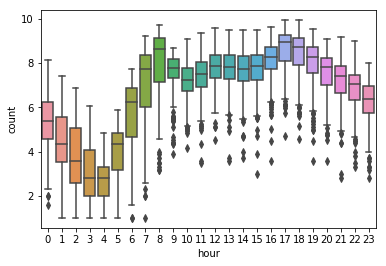

In [35]:
sns.boxplot('hour', 'count', data=train)

### weekday vs count

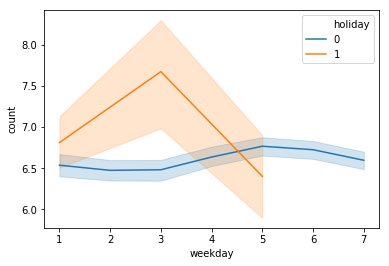

In [36]:
sns.lineplot('weekday', 'count', data=train, hue='holiday')

In [37]:
train.loc[(train.holiday==0) & (train.weekday<=5)]['workingday'].unique(), train.loc[ (train.weekday>=6) ]['workingday'].unique()

(array([1]), array([0]))

### month vs count

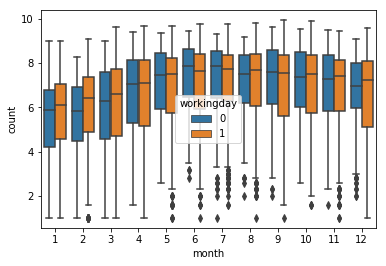

In [38]:
sns.boxplot('month', 'count', data=train, hue='workingday')

- before may, count on wokringday is higher than not working day
- after may, count on wokringday is lower than not working day

In [39]:

train['month_working'] = 0
train.loc[(train['month']>4) & (train['workingday']==1), 'month_working'] = 0
train.loc[(train['month']>4) & (train['workingday']==0), 'month_working'] = 1
train.loc[(train['month']<=4) & (train['workingday']==1), 'month_working'] = -1
train.loc[(train['month']<=4) & (train['workingday']==0), 'month_working'] = -2

### day vs count

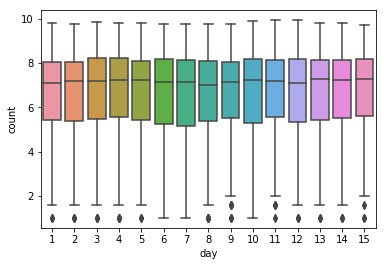

In [40]:
sns.boxplot('day', 'count', data=train)

### year vs count

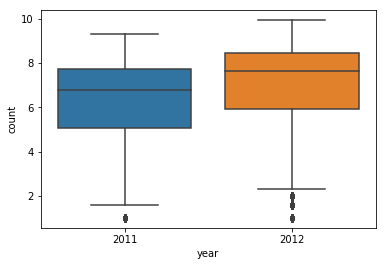

In [41]:
sns.boxplot('year', 'count', data=train)

# train with different models

In [42]:
df_data = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

df_train = df_data.iloc[:, :-3]
df_label = df_data['count']
train_ohc = pd.DataFrame()
test_ohc = pd.DataFrame()

X = pd.concat([df_train, df_test]).reset_index(drop=True)
# log label
df_label = np.log2(df_data['count'] + 1)
# transform tim
transform_time(X)
X.drop(['datetime', 'date', 'atemp', 'day'], axis=1, inplace=True)

X['bi_humid'] = 0

X.loc[X['humidity'] <=15, 'bi_humid'] = 1

X['month_working'] = 0
X.loc[(X['month']>4) & (X['workingday']==1), 'month_working'] = 0
X.loc[(X['month']>4) & (X['workingday']==0), 'month_working'] = 1
X.loc[(X['month']<=4) & (X['workingday']==1), 'month_working'] = -1
X.loc[(X['month']<=4) & (X['workingday']==0), 'month_working'] = -2

X['weekday_holiday'] = 0
X.loc[(X['holiday']==0), 'weekday_holiday'] = 1
X.loc[(X['weekday']<=3) & (X['holiday']==1), 'weekday_holiday'] = 2
X.loc[(X['weekday']>3) & (X['month']<=5) & (X['workingday']==1), 'weekday_holiday'] = 3
X.loc[(X['weekday']>5) & (X['holiday']==1), 'weekday_holiday'] = 4

#X.drop(['weekday'], axis=1, inplace=True)

class_features = [
    'season', 'weather', 'month', 'year', 'hour', 'weekday', 'weekday_holiday', 'month_working'
]

# data_ohc = pd.get_dummies(X, columns=class_features, drop_first=True)
def ohc(data, columns):
    for col in columns:
        temp = pd.get_dummies(X[col], prefix=col+'_', drop_first=True)
        data = pd.concat([data, temp], axis=1)
        data.drop(col, axis=1, inplace=True)
    return data

data_ohc = ohc(X, class_features)


In [43]:
data_ohc.head()

,holiday,workingday,temp,humidity,windspeed,bi_humid,season__2,season__3,season__4,weather__2,...,weekday__4,weekday__5,weekday__6,weekday__7,weekday_holiday__1,weekday_holiday__2,weekday_holiday__3,month_working__-1,month_working__0,month_working__1
0,0,0,9.84,81,0.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,9.02,80,0.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,9.02,80,0.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,9.84,75,0.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,9.84,75,0.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [44]:
# shuffle and split train and test
# data_ohc = data_ohc.sample(frac=1).reset_index(drop=True)
train_ohc = data_ohc[:df_train.shape[0]]
test_ohc = data_ohc[df_train.shape[0]:]


from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Xtrain_ohc = scaler.fit_transform(train_ohc)
Xtest_ohc = scaler.transform(test_ohc)

# to dataframe with column names
train_ohc = pd.DataFrame(Xtrain_ohc, columns=train_ohc.columns)
test_ohc = pd.DataFrame(Xtest_ohc, columns=test_ohc.columns)

train_ohc['count'] = df_label
all_features = test_ohc.columns

In [45]:
# try linear regression
model_base = LinearRegression()
model_base.fit(train_ohc[all_features], train_ohc['count'])
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv = np.sqrt(-cross_val_score(model_base, train_ohc[all_features], train_ohc['count'], cv=kf, scoring='neg_mean_squared_error').mean())
cv

3208407556393.499

In [46]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(train_ohc[all_features], train_ohc['count'])
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv = np.sqrt(-cross_val_score(dt, train_ohc[all_features], train_ohc['count'], cv=kf, scoring='neg_mean_squared_error').mean())
cv

0.8997718105477187

- the error come to sense when using decision trees, basic linear regression dont work well, suggests the relationship is not linear
- throught EDA, we see feature interations, try use kernel to construct high order features, and also use ridge to control the tendency of overfitting with large number of features

overfitting

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(train_ohc[all_features])
y = train_ohc['count']

In [48]:
all_features_after_poly = poly.get_feature_names(all_features)

In [ ]:
model = Lasso(alpha=0.1)
model.fit(X, y)

In [50]:
feature_imp = pd.DataFrame({'feature':all_features_after_poly, 'weight':model.coef_}).sort_values(by='weight', ascending=False)

In [51]:
feature_imp[np.abs(feature_imp['weight']) > 0.03]

,feature,weight
6958,temp month_working__-1^2,0.080984
4876,workingday hour__7^2,0.058511
4846,workingday hour__6^2,0.053924
37819,month_working__1^3,0.047138
4905,workingday hour__8^2,0.045495
30044,year__2012 month_working__-1^2,0.036856
4681,workingday hour__1^2,-0.032401
4716,workingday hour__2^2,-0.040650


- most important positive related feature is 
    - interaction term between temp and month_working__-1
    - interaction term between workingday and hour 6,7,8
    - month_working__1
    - year__2012 month_working__-1^2
- most important negative related feature is 
    - interaction term between workingday and hour1,2,3
- hour is very important as a single predictor (hour^3==hour, lasso randomly selects the feature that has the same content)